# Project: Compute allocations for a portfolio of equities using simulation
A central challenge is allocating wealth to the different assets that make up a portfolio. This has been a problem of intense study since the 1950s with the introduction of the [Minumin-Variance approach of Markowitz](https://en.wikipedia.org/wiki/Modern_portfolio_theory).  

### Learning objectives
This project will familiarize students with a simulation-based method of constructing multi-asset portfolios of equities using multi-asset geometric Brownian motion. Here, you'll couple the price simulation with a simple direct simulation approach to compute a `close-to-optimal` allocation vector $\omega$. Later, we'll explore the solution of the [Minumin-Variance optimization approach of Markowitz](https://en.wikipedia.org/wiki/Modern_portfolio_theory) in detail.

* __Prerequisite__: Load and clean the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) between `01-03-2018` and `12-29-2023`
* __Objective 1__: Compute the return covariance matrix $\Sigma$ for firms in ticker set $\mathcal{L}$ using the correlation matrix.
* __Objective 2__: Compute an optimal portfolio allocation using an evolutionary algorithm

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem. 
* See the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) for additional information on the functions and types used in this study. 

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
    Updating `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-3/Project.toml`
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
    Updating `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-3/Manifest.toml`
  [d3d80556] + LineSearches v7.2.0
  [429524aa] + Optim v1.9.4
  [d96e819e] + Parameters v0.12.3
  [85a6dd25] + PositiveFactorizations v0.2.4
  [3a884ed6] + UnPack v1.0.2
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
  [e66e0078] ↑ CompilerSupportLibraries_jll v1.0.5+1 ⇒ v1.1.1+0
  [453

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. 
* We load the `orignal_dataset` by calling the `MyMarketDataSet()` function and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ is stored in the `dataset` variable, where the dataset $\mathcal{D}$ has data for $\mathcal{L}$ firms, held in the `list_of_all_firms` variable (sorted alphabetically).

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Then, get a list of firms that we have in the cleaned-up `dataset` and save it in the `list_of_all_firms` array (we sort these alphabetically):

In [11]:
list_of_all_firms = keys(dataset) |> collect |> sort;

Finally, we set some constant values that are used throughout the study. In particular, the value of $\Delta{t}$ holds the time step that we'll use (see below for a discussion of the value), and we'll specify the number of trading days to simulate in the `T` variable:

In [13]:
Δt = (1.0/252.0);
T = 48;
all_range = range(1,stop=maximum_number_trading_days,step=1) |> collect;

To compare our portfolio performance to a benchmark, let's select the index for `SPY`:

In [15]:
index_for_SPY = findfirst(x-> x=="SPY", list_of_all_firms)

377

## Objective 1: Compute the return covariance matrix $\Sigma$ for firms in the ticker set $\mathcal{L}$
By computing the correlation, estimate the covariance matrix $\Sigma$ and the growth rate vector $\mu$ from the log growth (return) values. Begin by calculating the log growth array for $\mathcal{L}$ firms in `dataset` $\mathcal{D}$ and store this in the `log_growth_array` variable using the [log_growth_matrix(...) function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix).
* The `log_growth_array` will be a `N`$\times\dim\mathcal{L}$ array, with time values on the `rows` and firms on the `columns.` Once we have the `log_growth_array,` compute the covariance matrix $\Sigma$ by computing the correlation matrix from the `log_growth_array`; this is `approach 1` from the example.

In [89]:
log_growth_array = log_growth_matrix(dataset, list_of_all_firms);

Next, load the `Parameters-SP500-2018-2023.csv` file we saved previously in `module 2` using the `read(...)` function exported by the [CSV.jl package](https://github.com/JuliaData/CSV.jl). We will load this data into a [DataFrame](https://dataframes.juliadata.org/stable/), storing the values in the `parameters_df` variable:

In [19]:
parameters_df = CSV.read(joinpath(_PATH_TO_DATA, "Parameters-SP500-2018-2023.csv"), DataFrame);

Next, compute the [correlation](https://en.wikipedia.org/wiki/Correlation) between the firms in the `dataset` $\mathcal{D}$, i.e., between the columns in the `log_growth_array`. Use the [cor function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cor) exported by the [Statistics module, which is part of the Julia standard library](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics). 
* The [cor function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cor) takes the `log_growth_array` as an argument and produces the correlation matrix $\rho$, a symmetric $\dim\mathcal{D}\times\dim\mathcal{D}$ matrix where the elements $\rho_{ij}\in\rho$ describe the correlation between the returns of firm $i$ and $j$, and $p_{ii} = 1$. Let's store the correlation matrix in the $\rho$ variable.

In [21]:
ρ = cor(log_growth_array);

Compute the covariance matrix $\Sigma$. The matrix $\Sigma$ is a $\dim\mathcal{L}\times\dim\mathcal{L}$ symmetric array, where $\sigma_{ij}\in\Sigma$ equals $\sigma_{ij} = \sigma_{i}\cdot\sigma_{j}\cdot\rho_{ij}$ and $\sigma_{i}$ denotes the volatility of the returns of firm $i$, and $\rho_{ij}$ denotes the correlation between the return of firm $i$ and $j$.
* Use two nested `for` loops to compute $\sigma_{ij}\in\Sigma$. First, initialize storage for the $\Sigma$ array in the `Σ₁` variable. In the outer loop (index `i` below), select a `row_ticker` and get its volatility value $\sigma_{i}$.
* Then move into the inner loop (index `j` below), select a `column_ticker,` get $\sigma_{j}$, the volatility for firm $j$, and look up the correlation between firms $i$ and $j$. Finally, we'll compute $\sigma_{ij} = \sigma_{i}\cdot\sigma_{j}\cdot\rho_{ij}$.

In [23]:
Σ₁ = Array{Float64,2}(undef, length(list_of_all_firms), length(list_of_all_firms));
for i ∈ eachindex(list_of_all_firms)

    row_ticker = list_of_all_firms[i];
    σᵢ = parameters_df[i,:volatility];
    
    for j ∈ eachindex(list_of_all_firms)

        col_tikcer = list_of_all_firms[j];
        σⱼ = parameters_df[j,:volatility];
        Σ₁[i,j] = σᵢ*σⱼ*ρ[i,j];
    end
end

## Objective 2: Compute the future share price dynamics for firms in the ticker set $\mathcal{L}$
Now that we have the covariance $\Sigma$ and drift parameters $\mu$ from `module 2`, we can simulate the simultaneous price movement of multiple assets using the multi-asset geometric Brownian motion model. This allows us to project potential prices, i.e., the performance of portfolio $\mathcal{P}$

* First, we select some `tickers`$\in\mathcal{P}$ and compute the drift and covariance for the selected tickers. Then, we generate a random starting time index and initial share price for each ticker. Next, we simulate the share prices for all `tickers`$\in\mathcal{P}$ forward in time. Finally, we compare simulated versus observed market values.

In [25]:
my_list_of_tickers = ["AMD", "INTC", "MU", "PFE", "MRK", "WFC", "BAC", "GS", "AAPL", "MSFT", "TSLA"];
# my_list_of_tickers = rand(list_of_all_firms, 5);
my_list_of_firm_ids = Array{Int64,1}();
for ticker ∈ my_list_of_tickers
    firm_index = findfirst(x->x==ticker, list_of_all_firms);    
    push!(my_list_of_firm_ids, firm_index)
end

Now that you have selected the firm tickers in your risky portfolio compute the firm-specific drift vector and covariance matrix. We'll store these in the $\hat{\mu}$ and $\hat{\Sigma}$ variables. First, we'll construct the drift vector $\hat{\mu}$ using the `parameters_df` values, i.e., the values estimated from the previous module. 
* We initialize storage on `L1` to hold the drift values in the `μ̂` variable (type `Array{Float64,1}`). Then, we iterate through the indexes of our desired firms on `L2`, where for each iteration of the loop, we select the `:drift` field from `parameters_df` and append it (using the [push! function](https://docs.julialang.org/en/v1/base/collections/#Base.push!)) to the `μ̂` array.

In [27]:
μ̂ = Array{Float64,1}();
for firm_index ∈ my_list_of_firm_ids
    push!(μ̂, parameters_df[firm_index,:drift])
end

Next, we'll compute the firm-specific covariance $\hat{\Sigma}$ matrix for the `data` version of the problem. Note, you can use values from `parameters_df,` i.e., the values estimated from the previous module, by switching the covariance matrix to `Σ₁` on `L7`.
* We store the number of firms we have selected in the `my_number_of_selected_firm` variable by calling the [length function](https://docs.julialang.org/en/v1/base/arrays/#Base.length-Tuple{AbstractArray}) on `my_list_of_firm_ids` on `L1`. Then, we allocate storage for the firm-specific covariance `Σ̂` on `L2`, which is of type `Array{Float64,2}`.
* We then use nested `for` loops to fill in the `Σ̂` array values. The outer for loop $i$ iterates over the `rows,` and the inner for loop $j$ iterates over the `columns.` We select values from `my_list_of_firm_ids` (which correspond to the `row, column` coordinates in the original full covariance matrix), select the corresponding covariance value, and store it in the covariance matrix `Σ̂` on `L7`.

In [29]:
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂ = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂[i,j] = Σ₁[row_firm_index, col_firm_index]; # You choose either Σ₁ or Σ₂
    end
end

Finally, factor the covariance matrix $\Sigma = \mathbf{A}\mathbf{A}^{\top}$ using a [Cholesky factorization](https://en.wikipedia.org/wiki/Cholesky_decomposition) to get the $a_{ij}$ coefficients which appear in the noise term of the multi-asset geometric Brownian motion expression. We'll use the [Cholesky factorization](https://en.wikipedia.org/wiki/Cholesky_decomposition) routine implemented in the [LinearAlgebra.jl package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/) which is part of the [Julia standard library](https://docs.julialang.org/en/v1/)
* On `L1`, we call the [cholesky function](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.cholesky) with the covariance matrix `Σ̂` as an argument. This returns the matrix factorization in the [Cholesky type](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.Cholesky), which has the `L` and `U` fields, holding the `lower` and `upper` triangular factorizations, respectively. We convert the `lower` triangular factor into a [Matrix type](https://docs.julialang.org/en/v1/base/arrays/#Base.Matrix) to do computations with it later. We store this matrix in the variable $\mathbf{A}$, where the coefficients $a_{ij}\in\mathbf{A}$.

In [31]:
factors = cholesky(Σ̂);
A = factors.L |> x-> Matrix(x)
# Ā = diagm(0 => diag(A))

11×11 Matrix{Float64}:
 0.338796   0.0         0.0         …  0.0        0.0        0.0
 0.0841594  0.208311    0.0            0.0        0.0        0.0
 0.151774   0.113294    0.231253       0.0        0.0        0.0
 0.0319357  0.0290608  -0.00125944     0.0        0.0        0.0
 0.0150328  0.018916    0.00630693     0.0        0.0        0.0
 0.0543565  0.0568199   0.0494798   …  0.0        0.0        0.0
 0.0644211  0.0600112   0.0527376      0.0        0.0        0.0
 0.0704667  0.059483    0.0488338      0.0        0.0        0.0
 0.0939954  0.0577264   0.0287138      0.148344   0.0        0.0
 0.0914634  0.0529423   0.0190503      0.0617169  0.114202   0.0
 0.157493   0.0747993   0.0378182   …  0.0969713  0.0270217  0.344829

### TODO: Set the initial conditions, the time range, and other parameters
Now, we set up several constants and other data for the multi-asset simulation. Feel free to change these values and see what happens!
* We specify the simulation's starting date in the `startdate` variable, which is a [Date type](https://docs.julialang.org/en/v1/stdlib/Dates/#Dates). For this example, we'll select `Jan-03, 2023`, the first trading day of `2023`.
* We set the number of days we will simulate in the `T` variable and specify the number of sample paths we want to compute in the `number_of_trials` variable.
* The other variables, i.e., `Δt,` and `number_of_states,` are derived from the other constants or specified. 

In [33]:
startdate = Date(2023,01,03); # must be in the date range of the data, i.e., 03-Jan 2018 to 29-Dec, 2023
T = 250; # how many days will we simulate?
number_of_trials = 500; # number of sample paths we calculate

start_index = 1; # we are starting at the beginning of the year
stop_index = start_index + T

# ---- DO NOT CHANGE BELOW HERE ---------------------------- #
number_of_states = length(my_list_of_tickers);
# ---- DO NOT CHANGE ABOVE HERE ---------------------------- #

Next, get the initial share price, which we approximate as the [volume weighted average price](https://en.wikipedia.org/wiki/Volume-weighted_average_price) or `VWAP` for each asset in the portfolio for the `startdate`.  We store these values in the `Sₒ::Array{Float64,1}` variable.
* First, on `L1`, we initialize storage to hold the initial prices in the `Sₒ` variable, which is of type `Array{Float64,1}`. Then, we iterate through each `ticker` value in `my_list_of_tickers,` select the price data for `ticker` from `dataset,` and store it in the `price_df` variable (which is of type [DataFrame](https://dataframes.juliadata.org/stable/)).
* `L4` is a compound statement in which we first select trading days equal to or after the `startdate` from `price_df`, then select the first `VWAP` from this list and set it equal to the `startprice` variable.
* `L5` we use the [push! function](https://docs.julialang.org/en/v1/base/collections/#Base.push!) to add initial `VWAP` values to the `Sₒ` array.

In [35]:
Sₒ = Array{Float64,1}()
for ticker ∈ my_list_of_tickers
    price_df = dataset[ticker];
    startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:volume_weighted_average_price]
    push!(Sₒ,startprice)
end

### TODO: Run the multi-asset simulation to compute the share price trajectories
Following from the single asset case, we construct an instance of the `MyMultipleAssetGeometricBrownianMotionEquityModel` type, where we pass the drift vector $\mu$ and the factored covariance matrix $\mathbf{A}$ into the `build(...)` method:

In [37]:
model = build(MyMultipleAssetGeometricBrownianMotionEquityModel, (
        μ = μ̂, A = A
));

Then we pass the start time `T₁,` the stop time `T₂`  for the simulation, the initial conditions `Sₒ,` the time step `Δt,` and other simulation parameters along with the `model` instance into the `sample(...)` function. This function computes `number_of_paths` sample paths and returns the simulated data in the `simulation_dictionary` variable.
* The `simulation_dictionary` data structure holds a simulation array for each sample path, where the simulation array has time in the first column and the simulated price for each asset in columns $2\dots\dim\mathcal{L}$. Each row is a time value; each simulation array will have `T+1` rows.

In [39]:
T₁ = start_index*Δt
T₂ = stop_index*Δt
simulation_dictionary = VLQuantitativeFinancePackage.sample(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = number_of_trials);

### TODO: Build a Multivariate Log Normal Distribution of Final Share Prices
Finally, let's collect the simulated prices for all the assets at `T₂` and use these prices to estimate a [Multivariate Log Normal](https://en.wikipedia.org/wiki/Log-normal_distribution) distribution, i.e., the probability distribution that describes possible future prices for all the firms in $\mathcal{P}$.  
* First, let's iterate through the `simulation_dictionary` and collect the last time point for each of the firms in the portfolio $\mathcal{P}$, we'll store this data in the `final_share_price_array` variable.

In [41]:
final_share_price_array = Array{Float64,2}(undef, number_of_trials, length(my_list_of_tickers))
for i ∈ 1:number_of_trials
    data = simulation_dictionary[i];
    last_row_data = data[end,2:end]; # skip the time column
    for j ∈ eachindex(my_list_of_tickers)
        final_share_price_array[i,j] = last_row_data[j];
    end
end
final_share_price_array;

Now, we'll estimate the parameters for the multivariate LogNormal distribution, i.e., the log-transformed mean share prices and the covariance of the log-transformed share prices. We then construct an [MvLogNormal instance](https://juliastats.org/Distributions.jl/stable/multivariate/#Distributions.MvNormal) exported from the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl). Let's store the price distribution in the `final_price_d` variable:

In [43]:
mean_final_price = mean(log.(final_share_price_array),dims=1);
cov_final_price = cov(log.(final_share_price_array))
final_price_d = MvLogNormal(vec(mean_final_price), cov_final_price);

#### Visualize
Select an index for a firm in the portfolio $\mathcal{P}$, store this in the `firm_to_visualize` variable:

In [45]:
firm_to_visualize = 3;

`Unhide` the code block below to see how to sample and visualize the projected future share price of the firm corresponding to index `firm_to_visualize`:

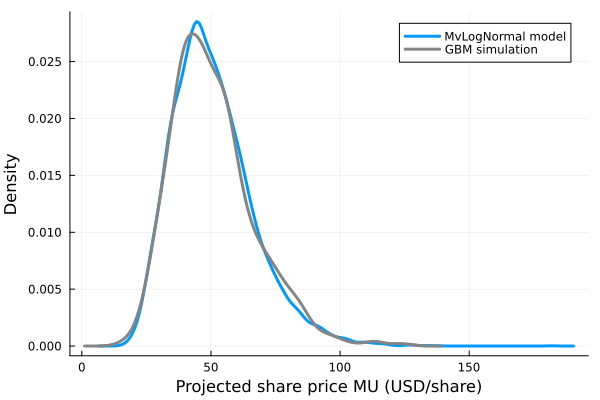

In [47]:
Z = rand(final_price_d,10000);
density(Z[firm_to_visualize,:], label="MvLogNormal model", lw=3)
density!(final_share_price_array[:,firm_to_visualize], label="GBM simulation", lw=3, c=:gray52)
xlabel!("Projected share price $(my_list_of_tickers[firm_to_visualize]) (USD/share)", fontsize=18)
ylabel!("Density", fontsize=18)

## Objective 3: Forward-looking portfolio allocation using Multivariate GBM
We know the distribution of possible future share prices, but how much of each firm in the portfolio $\mathcal{P}$ should we purchase? We'll explore this question later, but for now, let's develop a simple Monte-Carlo simulation algorithm to compute an allocation $\omega_{i}\in\omega$. We'll compare the performance of this allocation with a hypothetical alternative, e.g., investing the same amount of money in an index ETF such as `SPY` or `QQQ` for the same period.
* First, let's specify how much we wish to invest in risky assets and store this value in the `total_budget` variable:

In [49]:
total_budget = 1000.0;

Next, sample future price states by drawing samples from the `final_price_d` multivariate LogNormal distribution and possible allocations $\omega_{i}$ from a [Dirichlet distributions](https://en.wikipedia.org/wiki/Dirichlet_distribution) with parameters $\alpha_{i} = 1/\dim\mathcal{P}$, i.e., the expected allocation is eventually distributed over the possible $\dim\mathcal{P}$ alternatives.
* Once we have the sampled values, compute the net present value `NPV,` and store the `NPV` value in the first column, and the allocation $\omega_{i}$ in the remaining columns of the `NPV_simulation_array` where each row in `NPV_simulation_array` is a sample of the future price and a possible allocation.
* `Note`: This is not a `smart` approach in that we are selecting in a clever way values for $\omega_{i}$; we'll generate a bunch of possible alternatives and then analyze what we get. In particular, let's select the `maximum` and `minimum` values of the `NPV,` and then visualize. Denote the `maximum` (or `minimum`) allocation as $\omega_{i}^{\star}$.

In [51]:
number_of_samples = 5000;
d = Dirichlet(number_of_states, 1/number_of_states);
NPV_simulation_array = Array{Float64,2}(undef, number_of_samples, length(my_list_of_tickers)+1)
for i ∈ 1:number_of_samples

    S₂ = rand(final_price_d); # draw a sample from the price distribution
    ω = rand(d); # generate a random allocation
    NPV = 0.0;
    for j ∈ eachindex(my_list_of_tickers)
        ωⱼ = ω[j];
        ΔS = (1/𝒟(0.05,1))*S₂[j] - Sₒ[j];
        NPV += ((ωⱼ*total_budget)/(Sₒ[j]))*ΔS;
    end

    NPV_simulation_array[i,1] = NPV;
    for j ∈ eachindex(my_list_of_tickers)
        NPV_simulation_array[i,j+1] = ω[j]
    end
end
ω_max = NPV_simulation_array[:,1] |> v -> argmax(v) |> i -> NPV_simulation_array[i,2:end];
ω_min = NPV_simulation_array[:,1] |> v -> argmin(v) |> i -> NPV_simulation_array[i,2:end];

Now that we have $\omega_{i}^{\star}\in\omega$, which we selected based on the extreme net present value, we can compute how this portfolio actually performed. We'll compare our best (or worst) sampled portfolio with `SPY` or another benchmark such as `QQQ` for the same time period. 

* First, let's compute the performance of the portfolio $\mathcal{P}$ weighted using $\omega_{i}^{\star}\in\omega$ in `2023`. We'll store the value of each asset in the columns of the `actual_portfolio_performance_array`, with the portfolio's total value in the last column. Each row of the `actual_portfolio_performance_array` is a time point (in this case, each day).

In [53]:
# actual -
number_of_days = T;
actual_portfolio_performance_array = Array{Float64,2}(undef, number_of_days, length(my_list_of_tickers)+1)
for i ∈ eachindex(my_list_of_tickers)
    
    ticker = my_list_of_tickers[i];
    price_df = dataset[ticker];
    ticker_data = filter(:timestamp => x-> x >= startdate, price_df)
    nᵢ = (ω_max[i]*total_budget)/Sₒ[i];
    
    for j ∈ 1:number_of_days
        actual_portfolio_performance_array[j,i] = nᵢ*ticker_data[j,:volume_weighted_average_price];
    end
end

# total -
for i ∈ 1:number_of_days
    actual_portfolio_performance_array[i,end] = sum(actual_portfolio_performance_array[i,1:end-1])
end
actual_portfolio_performance_array;

Compute the performance of a benchmark alternative, e.g.,  `SPY` or `QQQ.` First, specify which benchmark to explore in the `benchmark_ticker` variable, then compute the initial number of shares of the benchmark and store it in the `n_benchmark` variable. Then iterate over `2023` and calculate the value of the benchmark, held in the `benchmark_portfolio` array:

In [55]:
benchmark_ticker = "SPY"
startprice_benchmark = filter(:timestamp => x-> x >= startdate, dataset[benchmark_ticker]) |> x-> x[1,:volume_weighted_average_price]
benchmark_portfolio = Array{Float64,1}(undef, number_of_days);
n_benchmark = (total_budget/startprice_benchmark);
for i ∈ 1:number_of_days
    price_df = dataset[benchmark_ticker];
    ticker_data = filter(:timestamp => x-> x >= startdate, price_df)
    benchmark_portfolio[i] = n_benchmark*ticker_data[i,:volume_weighted_average_price];
end

`Unhide` the code block below to see how we visualize the performance of the `actual portfolio` versus the `benchmark` portfolio:

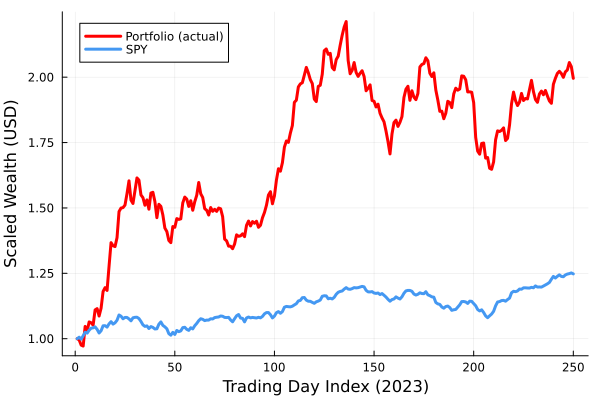

In [57]:
let
    p = plot();
    plot((1/actual_portfolio_performance_array[1,end]).*actual_portfolio_performance_array[:,end], lw=3, 
        c=:red, label="Portfolio (actual)")
    plot!((1/benchmark_portfolio[1]).*benchmark_portfolio, label="$(benchmark_ticker)", c=blue_color, lw=3)
    xlabel!("Trading Day Index (2023)", fontsize=18)
    ylabel!("Scaled Wealth (USD)", fontsize=18)
    current()
end

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.